# Imports

In [68]:
import SpotCurve.Spot_Curve_Calculator as sc
import matplotlib.pyplot as plt
import pandas as pd
import mpl_bsic
import importlib
import Returns.RollDown as rd
from Utils.data_processing import process_data
import Utils.CrossSectional_Regression as csr

importlib.reload(sc)
importlib.reload(rd)
importlib.reload(csr)

<module 'Utils.CrossSectional_Regression' from '/Users/vittoriomanfriani/PycharmProjects/backtesting series - episode 3/Utils/CrossSectional_Regression.py'>

# Load Data

In [49]:
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/BSIC/Datasets/bond_data_auction.parquet')
# take data only from 2010-01-01
data = data.loc[(data.index.get_level_values(0) >= '2010-01-01') & (data.index.get_level_values(0) <= '2024-10-02')]

# Apply Bootstrapper

In [50]:
spot_rates_calculator = sc.SpotRatesCalculator()

In [51]:
zero_curve_df = spot_rates_calculator.apply_bootstrapper(data,freq = 'tenors')

100%|██████████| 3847/3847 [00:54<00:00, 71.22it/s]


# Apply Nelson Siegel Svensson

In [76]:
loadings_df = spot_rates_calculator.apply_nelson_siegel(zero_curve_df, ridge=False)

100%|██████████| 3847/3847 [00:15<00:00, 243.41it/s]


In [53]:
loadings_df.head()

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Beta3 (Second Curvature),Lambda1,Lambda2
Date,,,,,,
2010-01-01,5.617342,-5.933011,-2.303588,-2.275384,1.427338,1.427333
2010-01-04,5.659167,-5.413080,-3.036872,-3.284200,1.312777,1.312808
2010-01-05,5.650661,-5.772935,-2.676113,-2.717506,1.424635,1.424634
2010-01-06,5.749927,-5.642614,-3.016228,-3.224737,1.362159,1.362132
2010-01-07,5.744017,-6.125500,-2.354645,-2.335579,1.501866,1.501896


## Interpolate with Nelson-Siegel-Svensonn

In [54]:
interpolated_curve_df = spot_rates_calculator.interpolate_nelson_siegel_svensson(loadings_df, freq = 'quarterly')

100%|██████████| 3847/3847 [00:03<00:00, 1052.96it/s]


### Plot and compare the two curves

fonts already added so will not add again


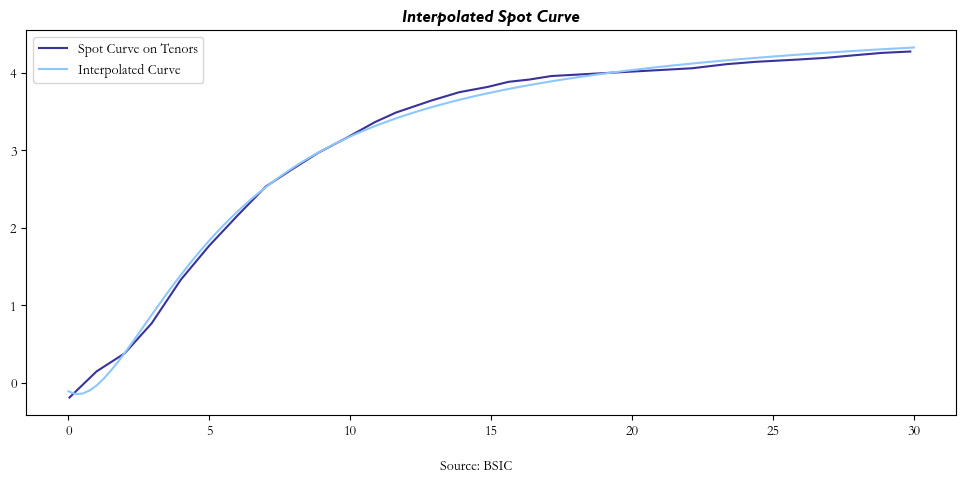

In [77]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(zero_curve_df.loc['2014-01-01', 'Maturities'], zero_curve_df.loc['2014-01-01','Curve'], label = 'Spot Curve on Tenors')
ax.plot(interpolated_curve_df.loc['2014-01-01', 'Maturities'], interpolated_curve_df.loc['2014-01-01','Curve'], label = 'Interpolated Curve')
ax.legend()
ax.set_title('Interpolated Spot Curve')
mpl_bsic.apply_bsic_style(fig, ax)

# Compute Returns

## Overall returns

In [56]:
# Function to compute returns
def compute_gross_returns(df):
    # Calculate daily coupons (coupon/365) and lagged price
    df.loc[:, 'daily_coupons'] = df['coupon'] / 365
    df.loc[:, 'prev_price'] = df.groupby('id')['price'].shift(1)  # Lagged price for each bond

    # Compute returns using the formula
    df.loc[:, 'returns'] = ((df['price'] + df['daily_coupons']) - df['prev_price']) / df['prev_price']

    return df

In [57]:
data = process_data(data)
data = compute_gross_returns(data)

# Carry

In [58]:
def compute_carry(df):
    df['carry'] = df['daily_coupons'] / df['prev_price']
    return df

In [59]:
data = compute_carry(data)

## RollDown

In [64]:
data = rd.compute_rolldown(data)

100%|█████████▉| 3846/3847 [07:26<00:00,  8.61it/s]


## Excess returns

In [66]:
data['Excess Returns'] = data['returns'] - data['carry'] - data['rolldown']

# Cross Sectional Regression

In [78]:
params = csr.cross_sectional_regression_nelson_siegel(data, loadings_df, nss = False)

100%|██████████| 3847/3847 [00:10<00:00, 376.97it/s]


In [75]:
params.mean()

date         2017-05-18 20:46:25.647425792
const                             0.000486
beta1                             0.000272
beta2                              -0.0029
r_squared                         0.669961
dtype: object

In [72]:
loadings_df.corr()

,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Beta3 (Second Curvature),Lambda1,Lambda2
Beta0 (Level),1.000000,-0.385695,0.216899,-0.228309,-0.388257,-0.100030
Beta1 (Slope),-0.385695,1.000000,0.015991,-0.002063,-0.138393,-0.081266
Beta2 (Curvature),0.216899,0.015991,1.000000,-0.999673,-0.361963,-0.480654
Beta3 (Second Curvature),-0.228309,-0.002063,-0.999673,1.000000,0.357417,0.471441
Lambda1,-0.388257,-0.138393,-0.361963,0.357417,1.000000,0.502896
Lambda2,-0.100030,-0.081266,-0.480654,0.471441,0.502896,1.000000
